# 6. LSTM, GRU, BI_LSTM, BI_GRU

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# 시드 설정
seed_value = 42
tf.random.set_seed(seed_value)

2024-11-14 08:46:50.342975: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 08:46:50.383131: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 08:46:51.096394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/paradeigma/workspace/python/nlp_module/nlp_module_3_9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user

In [2]:
# 'imdb_reviews' 데이터셋을 로드하고, 정보(info)와 함께 로드 (as_supervised=True는 (input, label) 쌍으로 로드)
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
print(
    type(dataset), len(dataset), dataset.keys(), len(dataset['train']), 
)
print("-"*30)
# negative:0 / positive: 1
for x in dataset['train']:
    break
print(len(x))
print(x[0].numpy())
print(x[1].numpy())

2024-11-14 08:46:55.442263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 08:46:55.659754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 08:46:55.659804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 08:46:55.671055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 08:46:55.671107: I tensorflow/compile

<class 'dict'> 3 dict_keys(['train', 'test', 'unsupervised']) 25000
------------------------------
2
b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
0


r/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 08:46:56.218202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 08:46:56.218262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 08:46:56.218268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1726] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-11-14 08:46:56.218286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to r

In [3]:
# 훈련용 문장과 레이블을 저장할 리스트 초기화
train_sentences = []
train_labels = []

# 테스트용 문장과 레이블을 저장할 리스트 초기화
test_sentences = []
test_labels = []

# 훈련 데이터셋의 각 (문장, 레이블) 쌍에 대해 반복
for sent, label in dataset['train']:
    train_sentences.append(str(sent.numpy()))    # 문장을 문자열로 변환하여 리스트에 추가
    train_labels.append(label.numpy())    # 레이블을 numpy 형식으로 변환하여 리스트에 추가

# 테스트 데이터셋의 각 (문장, 레이블) 쌍에 대해 반복
for sent, label in dataset['test']:
    test_sentences.append(str(sent.numpy()))     # 문장을 문자열로 변환하여 리스트에 추가
    test_labels.append(label.numpy())     # 레이블을 numpy 형식으로 변환하여 리스트에 추가

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print(train_labels[-1])   # 훈련 데이터셋의 마지막 레이블 출력
print(train_sentences[-1])    # 훈련 데이터셋의 마지막 문장 출력
print(len(train_sentences), len(train_labels))

print(test_labels[-1])    # 테스트 데이터셋의 마지막 레이블 출력
print(test_sentences[-1])    # 테스트 데이터셋의 마지막 문장 출력
print(len(test_sentences), len(test_labels))

1
b'First of all, Riget is wonderful. Good comedy and mystery thriller at the same time. Nice combination of strange \'dogma\' style of telling the story together with good music and great actors. But unfortunately there\'s no \'the end\'. As for me it\'s unacceptable. I was thinking... how it will be possible to continue the story without Helmer and Drusse? ...and I have some idea. I think Lars should make RIGET III a little bit different. I\'m sure that 3rd part without Helmer wouldn\'t be the same. So here\'s my suggestion. Mayble little bit stupid, maybe not. I know that Lars likes to experiment. So why not to make small experiment with Riget3? I think the only solution here is to create puppet-driven animation (like for example "team America" by Trey Parker) or even computer 3d animation. I know it\'s not the same as real actors, but in principle I believe it could work... only this way it\'s possible to make actors alive again. For Riget fans this shouldn\'t be so big difference 

In [4]:
import numpy as np
import re
from konlpy.tag import Okt

def text_preprocessing(corpus, lang, stop_words=None, tokenizer=None, pos_tags=None):
    """
    This is a text preprocessing function. It processes the given list of texts (corpus) by removing stopwords and performing POS tagging based on the specified language.

    Parameters:
    - corpus (list of str): A list of texts to be preprocessed.
    - lang (str): Specifies the language of the text. Must be either 'eng' or 'kor'.
        - 'eng': Preprocesses English texts.
        - 'kor': Preprocesses Korean texts.
    - stop_words (list of str, optional): A list of stopwords to be removed. Default is None.
    - tokenizer (Okt, optional): A Korean tokenizer (morphological analyzer) object, primarily using Okt. Default is None.
        - Not used when 'lang' is 'eng'.
        - If 'lang' is 'kor' and no tokenizer is provided, an Okt object will be automatically created.
    - pos_tags (list of str, optional): A list of POS tags to filter when processing Korean texts.
        - If provided, only the specified POS tags will be retained. Default is None.

    Returns:
    - list of str: A list of preprocessed texts.
    """
    if lang == 'eng':
        cleaned_corpus = [re.sub(r'[^a-zA-Z ]', '', text).lower() for text in corpus]
        results = []
        if stop_words:
            for text in cleaned_corpus:
                filtered_text = ' '.join(word for word in text.split() if word not in stop_words)
                results.append(filtered_text)
        else:
            results = cleaned_corpus
                
    elif lang == 'kor':
        if tokenizer is None:
            tokenizer = Okt()
            
        cleaned_corpus = [re.sub(r'[^가-힣 ]', '', text).lower() for text in corpus]
        results = []
        if stop_words or pos_tags:
            for text in cleaned_corpus:
                morphs_with_pos = tokenizer.pos(text)
                filtered_morphs = [
                    word for word, pos in morphs_with_pos 
                    if (pos_tags is None or pos in pos_tags) and (word not in stop_words if stop_words else True)
                ]
                filtered_text = ' '.join(filtered_morphs)
                results.append(filtered_text)
        else:
            for text in cleaned_corpus:
                filtered_text = ' '.join(tokenizer.morphs(text))
                results.append(filtered_text)
                
    else:
        raise ValueError("The 'lang' parameter must be either 'eng' or 'kor'.")
                
    return results

lang = 'eng'
train_sentences = text_preprocessing(corpus=train_sentences, lang='eng')
test_sentences = text_preprocessing(corpus=test_sentences, lang='eng')

# Begin of Statement TOKEN을 위한 추가 처리
train_sentences = [text[0]+" "+text[1:] for text in train_sentences]
test_sentences = [text[0]+" "+text[1:] for text in test_sentences]
train_sentences[0], test_sentences[0], len(train_sentences), len(test_sentences)

('b this was an absolutely terrible movie dont be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movies ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the columbian rebels were making their cases for revolutions maria conchita alonso appeared phony and her pseudolove affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actors like christopher walkens good name i could barely sit through it',
 'b there are films that make careers for george romero it was night of the living dead for kevin smith clerks for robert rodriguez el mariachi add to that list onur tukels absolutely amazing dingalingless flawless filmmaking and as assured and as professional as any of the aforementioned movies i ha

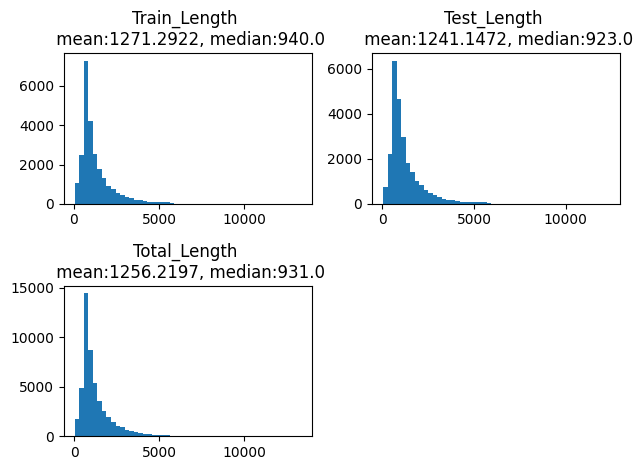

In [5]:
train_length_lst = [len(text) for text in train_sentences] 
test_length_lst = [len(text) for text in test_sentences] 
plt.subplot(2,2,1)
plt.hist(train_length_lst, bins=50)
mean = np.mean(train_length_lst)
median = np.median(train_length_lst)
plt.title(f"Train_Length \n mean:{mean}, median:{median}")
plt.subplot(2,2,2)
plt.hist(test_length_lst, bins=50)
mean = np.mean(test_length_lst)
median = np.median(test_length_lst)
plt.title(f"Test_Length \n mean:{mean}, median:{median}")
plt.subplot(2,2,3)
plt.hist(train_length_lst+test_length_lst, bins=50)
mean = np.mean(train_length_lst+test_length_lst)
median = np.median(train_length_lst+test_length_lst)
plt.title(f"Total_Length \n mean:{mean}, median:{median}")
plt.tight_layout()

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels, test_size = 0.2)

total_sentences = train_sentences + val_sentences + test_sentences
num_words = 10000
padding = 'post'
truncating = "post"
oov_token = "<OOV>"
one_hot = False
max_len = 150

# Tokenizer 생성 및 문장 학습
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)
total_sentences = tokenizer.texts_to_sequences(total_sentences)
padded = pad_sequences(total_sentences, maxlen=max_len, padding=padding, truncating=truncating)
word_index = tokenizer.word_index
index_word = tokenizer.index_word

print(padded.shape)

(50000, 150)


In [7]:
X_train = np.array(padded[:len(train_sentences)])
y_train = np.array(train_labels)
X_val = np.array(padded[len(train_sentences):len(train_sentences)+len(val_sentences)])
y_val = np.array(val_labels)
X_test = np.array(padded[len(train_sentences)+len(val_sentences):])
y_test = np.array(test_labels)

In [8]:
# Train, validation, test dataset 생성 및 배치 단위로 분리
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [9]:
from tensorflow.keras import layers, models
import tensorflow as tf

# return_sequence = false, return_state = false
def rnn_model(vocab_size, dim_lst, loss_fn, optimizer, metrics):
    # 입력 레이어
    inputs = layers.Input(shape=(None,), dtype="int32")  # 입력의 모양을 지정 (단어 인덱스 시퀀스)
    x = layers.Embedding(vocab_size + 1, dim_lst[0])(inputs)  # 어휘 크기 + 1, 임베딩 차원 64
    x = layers.LSTM(dim_lst[1])(x)
    x = layers.Dense(dim_lst[2], activation='relu')(x)
    outputs = layers.Dense(dim_lst[3], activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
    return model

# 모델 생성
vocab_size = num_words  # 예시로 어휘 크기 설정
dim_lst = [128, 128, 64, 1]
loss_fn = 'binary_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']
model = rnn_model(
    vocab_size=vocab_size, dim_lst=dim_lst, loss_fn=loss_fn, optimizer=optimizer, metrics=metrics
)

# 모델 요약 출력
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         1280128   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1420033 (5.42 MB)
Trainable params: 1420033 (5.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
import time
# 모델 학습 시간 측정
start_time = time.time()

# 모델 학습 (검증 데이터 포함)
epochs = 10
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, verbose=1)

# 모델 테스트 평가
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
end_time = time.time()
evaluation_time = end_time - start_time
print(f"Evaluation Time: {evaluation_time:.2f} seconds")

Epoch 1/10


2024-11-14 08:47:09.323126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-14 08:47:09.399600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-14 08:47:09.494633: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6441dba5c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-14 08:47:09.494692: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-14 08:47:09.545690: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-14 08:47:09.837221: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

313/313 [==============================] - 28s 85ms/step - loss: 0.6888 - accuracy: 0.5347 - val_loss: 0.6936 - val_accuracy: 0.4992
Epoch 2/10
313/313 [==============================] - 6s 20ms/step - loss: 0.6569 - accuracy: 0.6058 - val_loss: 0.6754 - val_accuracy: 0.5674
Epoch 3/10
313/313 [==============================] - 6s 19ms/step - loss: 0.5990 - accuracy: 0.6726 - val_loss: 0.5345 - val_accuracy: 0.7504
Epoch 4/10
313/313 [==============================] - 6s 19ms/step - loss: 0.4864 - accuracy: 0.7768 - val_loss: 0.6802 - val_accuracy: 0.5540
Epoch 5/10
313/313 [==============================] - 6s 19ms/step - loss: 0.5463 - accuracy: 0.7193 - val_loss: 0.5447 - val_accuracy: 0.7360
Epoch 6/10
313/313 [==============================] - 6s 20ms/step - loss: 0.4853 - accuracy: 0.7537 - val_loss: 0.4290 - val_accuracy: 0.8156
Epoch 7/10
313/313 [==============================] - 6s 20ms/step - loss: 0.2831 - accuracy: 0.8857 - val_loss: 0.4210 - val_accuracy: 0.8280
Epoch 8/1

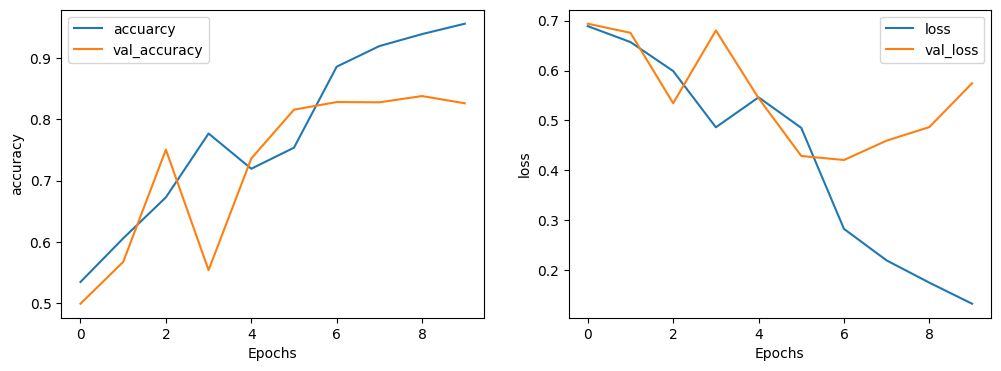

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('accuracy')
ax1.legend(['accuarcy', 'val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('loss')
ax2.legend(['loss', 'val_loss'])
plt.show()

In [12]:
sample_texts = [
    'The movie was terrible. I would not recommend the movie', # 0
    'The movie was fantastic. I would recommend the movie', # 1
    'The animation and graphics were out of this world' # 1
    ]

sample_text_ = text_preprocessing(corpus=sample_texts, lang='eng')
sample_sequences = tokenizer.texts_to_sequences(sample_text_)
sample_padded = pad_sequences(sample_sequences, maxlen=max_len, padding=padding, truncating=truncating)

In [13]:
sample_padded[2]

array([   2,  744,    3, 2822,   68,   47,    5,   11,  191,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], d

In [14]:
model.predict(*[sample_padded])

1/1 [==============================] - 0s 202ms/step


array([[0.02010467],
       [0.97020096],
       [0.97539335]], dtype=float32)